In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import mediapipe as mp
import math
import os
import landmarks as lm
import mask as m
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import pickle

# Load datasets

In [2]:
dataPath = './resources/features/'

# load from the NPZ files
landmarksJaffe = pd.read_csv(dataPath+'landmarksJaffe.csv')
croppedJaffe = np.load(dataPath+'CroppedJaffe.npz')['img']
# faceMaskJaffe = np.load(writeDataPath+'features/faceMaskJaffe.npz')['img']

landmarksKDEF = pd.read_csv(dataPath+'landmarksKDEF.csv')
croppedKDEF = np.load(dataPath+'CroppedKDEF.npz')['img']
# faceMaskKDEF = np.load(writeDataPath+'features/faceMaskKDEF.npz')['img']

landmarksCKPLUS = pd.read_csv(dataPath+'landmarksCKPLUS.csv')
croppedCKPLUS = np.load(dataPath+'CroppedCKPLUS.npz')['img']
# faceMaskCKPLUS = np.load(writeDataPath+'features/faceMaskCKPLUS.npz')['img']

landmarksCustom = pd.read_csv(dataPath+'landmarksCustom.csv')
croppedCustom = np.load(dataPath+'CroppedCustom.npz')['img']

# Concatenate datasets

In [3]:
X_img = np.concatenate([croppedJaffe, croppedKDEF, croppedCKPLUS, croppedCustom], axis=0)
X_3D = pd.concat([landmarksJaffe, landmarksKDEF, landmarksCKPLUS, landmarksCustom], axis=0, ignore_index=True)

In [4]:
# extract labels
y = X_3D['emotion'].astype('int8')

print(f"X_img shape: {np.shape(X_img)}, \nX_3D shape: {np.shape(X_3D)} \ny shape: {y.shape}")
print("\nX_3D dataframe")
X_3D.iloc[:-1]

X_img shape: (4088, 96, 96, 3), 
X_3D shape: (4088, 207) 
y shape: (4088,)

X_3D dataframe


,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F197,F198,F199,F200,F201,F202,F203,F204,F205,emotion
0,44.128837,68.560268,93.071849,92.710403,71.906616,66.572590,29.545760,91.617512,132.386512,88.637279,...,75.992846,120.712808,97.304526,44.128837,35.719082,100.026856,90.139713,49.167116,147.045393,0.0
1,37.238257,67.987445,89.386593,110.526283,63.984613,65.514341,34.475927,97.512647,123.237709,88.271540,...,78.785016,127.192863,90.122298,35.420648,29.298904,106.261943,97.850647,48.756323,150.277082,0.0
2,42.934561,62.777480,69.504805,75.214753,68.584171,64.770910,22.550336,87.700227,122.738894,86.606210,...,77.298659,125.807840,96.004598,49.147319,33.825505,100.215887,99.259911,49.147319,156.639643,0.0
3,41.078402,80.963179,88.617511,80.561374,61.880366,64.449099,29.046817,105.347667,133.595925,94.294671,...,74.709545,133.595925,92.206707,54.042213,30.143306,105.039181,88.617511,51.584449,149.419090,0.0
4,41.722423,81.824403,77.625445,81.002027,70.388013,65.459523,29.502208,98.868803,129.375741,84.243379,...,67.968454,133.451563,93.652310,53.028274,36.592986,102.525684,90.006844,52.393182,152.860600,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4082,40.404396,50.331037,70.782292,98.113252,62.323834,62.323834,27.052119,111.538745,121.213187,97.537803,...,78.691162,135.052343,84.219933,48.042052,38.257474,95.201229,90.034895,49.199858,148.739355,6.0
4083,57.110559,87.565167,94.176995,91.088381,50.177073,75.644783,43.454620,99.782322,95.982470,112.454055,...,72.160524,116.207721,93.872707,59.080464,44.752057,82.864708,86.909239,61.454112,173.983001,6.0
4084,43.654520,45.894651,85.568487,92.605222,67.555097,57.531989,35.408492,110.165372,122.249067,94.746666,...,71.170187,133.241359,86.152579,53.465650,30.045102,98.382098,84.090509,53.465650,152.050512,6.0
4085,44.094566,62.359133,94.896372,67.860105,69.351714,54.476258,29.492917,89.912861,105.371495,108.481877,...,73.297291,111.963461,72.947421,47.448186,32.779545,110.120315,84.636421,52.075231,159.467236,6.0


# View sample images

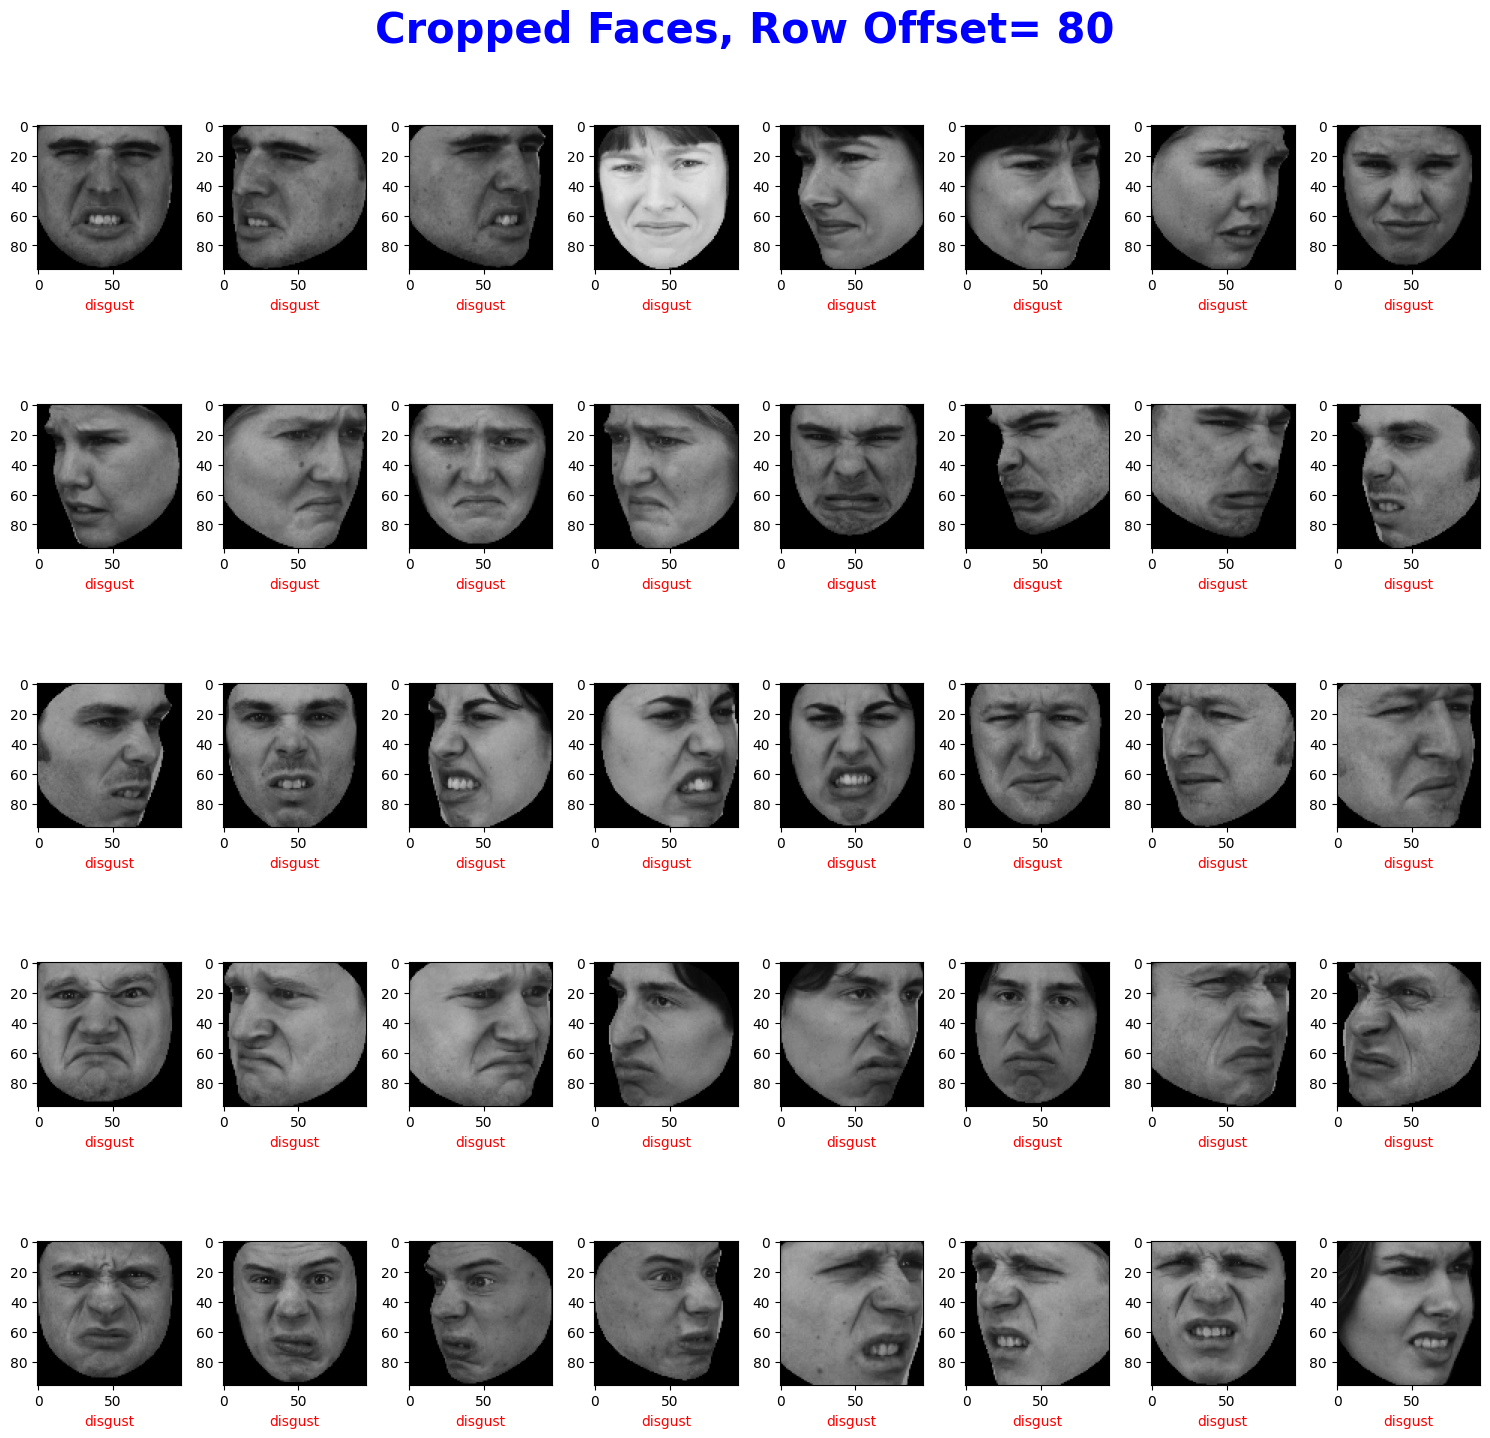

In [5]:
emo = ['angry',
        'disgust',
        'fear',
        'happy',
        'sad',
        'surprise',
        'neutral'
]

rowOffset = 80
nRows = 5
nCols = 8
fig, axes = plt.subplots(nRows, nCols, figsize=(15, 15))
fig.suptitle(f'Cropped Faces, Row Offset= {rowOffset}', fontsize=30, color='blue', fontweight='bold')
for i in range(nRows):
    for j in range(nCols):
        ax = axes[i, j]
        ax.imshow(X_img[(i+rowOffset)*nCols+j,:,:], cmap='gray')
        ax.set_xlabel(emo[y.iloc[(i+rowOffset)*nCols+j]], c='r')
plt.tight_layout()
plt.show()

In [6]:
# string labels
emo = ['angry', 
            'disgust',
            'fear',
            'happy',
            'sad',
            'surprised',
            'neutral'
]

# count classes
emotions, counts =np.unique(y, return_counts=True)
for c, count in zip(emotions, counts):
    print(f"{emo[c]} count = {count}")

angry count = 569
disgust count = 602
fear count = 538
happy count = 654
sad count = 518
surprised count = 664
neutral count = 543


# Gabor Filtering

In [7]:
def gabor_filter(image, theta, lambd):
    '''
    This function
    '''
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Create the Gabor kernel
    kernel_size = 3  # Size of the kernel
    sigma = 1  # Standard deviation of the Gaussian envelope
    gamma = 0.5  # Aspect ratio of Gaussian envelope
    psi = 290*(np.pi/180)  # Phase offset of sinusoidal function #290
    gabor_kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
    
    # # display kernel
    # # kernelVisual = np.uint8((gabor_kernel+1)/2 *255)
    # cv2.imshow('Kernel',cv2.resize(gabor_kernel,(400,400)))
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # cv2.waitKey(1)
    
    # Filter the image using the Gabor kernel
    filtered_image = cv2.filter2D(gray, -1, gabor_kernel) # convolute image
    
    return filtered_image

# Display gabor images

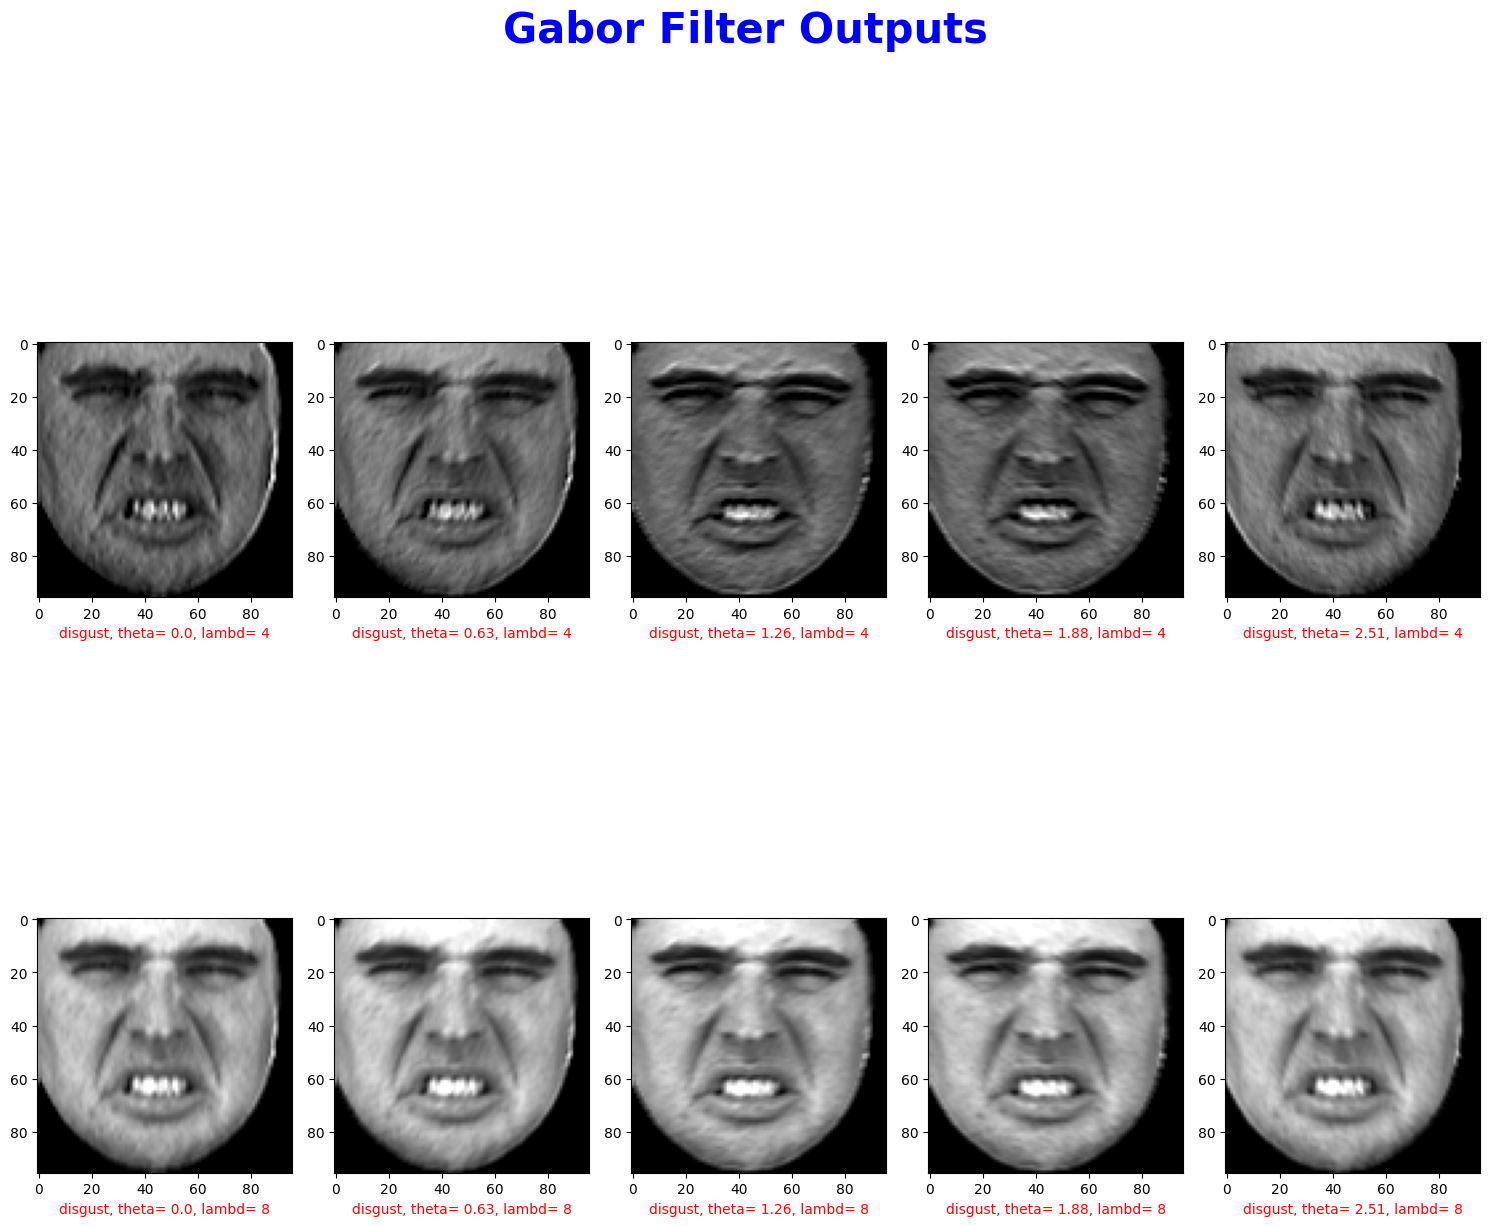

In [20]:
n = 640
numLambd = 2
numTheta = 5
fig, axes = plt.subplots(numLambd, numTheta, figsize=(15, 15))
fig.suptitle(f'Gabor Filter Outputs', fontsize=30, color='blue', fontweight='bold')
lambdVal = [4,8] #3,4


for i in range(numLambd):
    for j in range(numTheta):
        ax = axes[i, j]
        theta = j*(np.pi/numTheta)
        lambd = lambdVal[i] #4
        filtered_image = gabor_filter(cv2.resize(X_img[n,:,:],(96,96)), theta, lambd)
        ax.imshow(filtered_image, cmap='gray')
        ax.set_xlabel(f"{emo[y[n]]}, theta= {round(theta,2)}, lambd= {round(lambd,2)}", c='r')
        
plt.tight_layout()
plt.show()

# Extract gabor features

In [9]:
gaborFeatures = [] #
numImgPerFeature = numLambd*numTheta

for image in X_img:
    gaborImages = []
    for i in range(numLambd):
        for j in range(numTheta):
            theta = j*(np.pi/numTheta)
            lambd = lambdVal[i]
            filtered_image = gabor_filter(cv2.resize(image,(96,96)), theta, lambd)
            # filtered_image = gabor_filter(cv2.resize(image,(96,96)), theta=(j+1)*(np.pi/3), lambd=(i+1)*4)
            gaborImages.append(np.array(filtered_image).reshape(96*96))
    gaborFeatures.append(np.array(gaborImages).reshape(numImgPerFeature*96*96))

print(f"gaborFeatures shape: {np.array(gaborFeatures).shape}")

gaborFeatures shape: (4088, 92160)


# Dimensionality reduction

In [10]:
# Reduce dimensionality using PCA
n_components = 40
pca = PCA(n_components= n_components)
reduced_gaborFeatures = pca.fit_transform(gaborFeatures)
print(f"gaborFeatures_scaled shape after PCA reduction: {reduced_gaborFeatures.shape}")
print(f"Explained variance: {round(np.cumsum(pca.explained_variance_ratio_ * 100)[-1],2)}%")

gaborFeatures_scaled shape after PCA reduction: (4088, 40)
Explained variance: 80.27%


In [11]:
# # Save the fitted PCA model to a file
# with open('./datasets/combiModels/pca_svm_gabor_pp.pkl', 'wb') as file:
#     pickle.dump(pca, file)

In [12]:
# Array information
print(f"reduced_gaborFeatures type: {type(reduced_gaborFeatures)}, shape: {reduced_gaborFeatures.shape}")

reduced_gaborFeatures type: <class 'numpy.ndarray'>, shape: (4088, 40)


In [13]:
# generate header of dataset
hds = []
for i in range(reduced_gaborFeatures.shape[1]):
    hds.append('F'+str(i))

reduced_gaborFeatures = pd.DataFrame(reduced_gaborFeatures,columns=hds)
    
reduced_gaborFeatures.tail()


,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F30,F31,F32,F33,F34,F35,F36,F37,F38,F39
4083,15340.548713,7095.054657,-7853.889314,912.329954,10439.000741,4208.852950,3004.048630,-1484.911081,663.494730,5634.739862,...,499.115163,199.531656,26.777298,3089.999561,-1122.653609,-349.116671,-871.233513,-21.826767,-140.222768,1941.318266
4084,483.527503,4388.504960,28.733000,-6065.347381,2595.193243,-2428.037359,8995.878348,-1237.600398,-3850.845541,2669.975148,...,44.742103,1492.727490,-164.645962,695.881894,900.596590,521.006906,-1284.545195,-1702.894558,-580.591369,86.018234
4085,9469.297672,-1363.959705,1491.785318,-8602.807077,-1080.966854,-4108.058891,3285.493265,5669.800867,-1692.720379,-2530.343569,...,-342.475026,501.675886,1121.176396,-1619.888347,-527.998998,1456.799771,2428.585870,-1694.279640,1134.581553,-978.797118
4086,-7791.822209,10324.680894,2488.629685,-1880.679939,-235.587540,-1981.021982,-4909.616273,5013.877720,3564.386950,3104.205655,...,119.882354,-959.741617,3118.754731,-223.084114,-7.183587,1739.638485,994.305063,386.871039,-1328.493933,-2371.274653
4087,3522.188705,7616.902347,2729.696139,-6952.862512,400.271281,-1394.970175,464.410677,-2182.572893,944.811781,2086.459689,...,220.031286,339.922511,429.571658,248.150133,-1056.113415,1169.801376,895.759280,61.447291,-591.106925,-611.852803


# Write out to CSV file

In [14]:
# # write combined 3d and labels to csv file
# reduced_gaborFeatures.to_csv(dataPath+'gaborPCA.csv', index=False)